[*********************100%***********************]  1 of 1 completed


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 20, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 20, 32)         │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_4 (Attention)         │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,137 (27.88 KB)

 Trainable params: 7,137 (27.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0404 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0225 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0135 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0082 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0051 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0021 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0014 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.7404e-04 - val_loss: 7.4916e-04 - learning_rate: 0.0010
Epoch 10/50
6

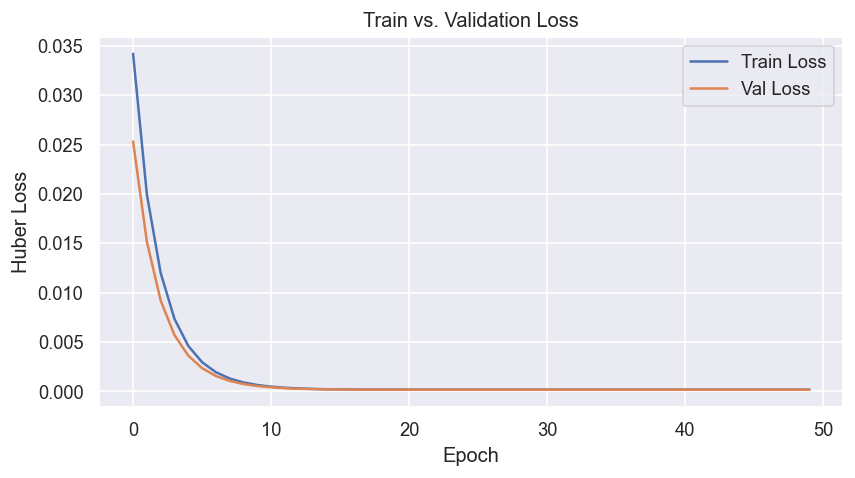

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


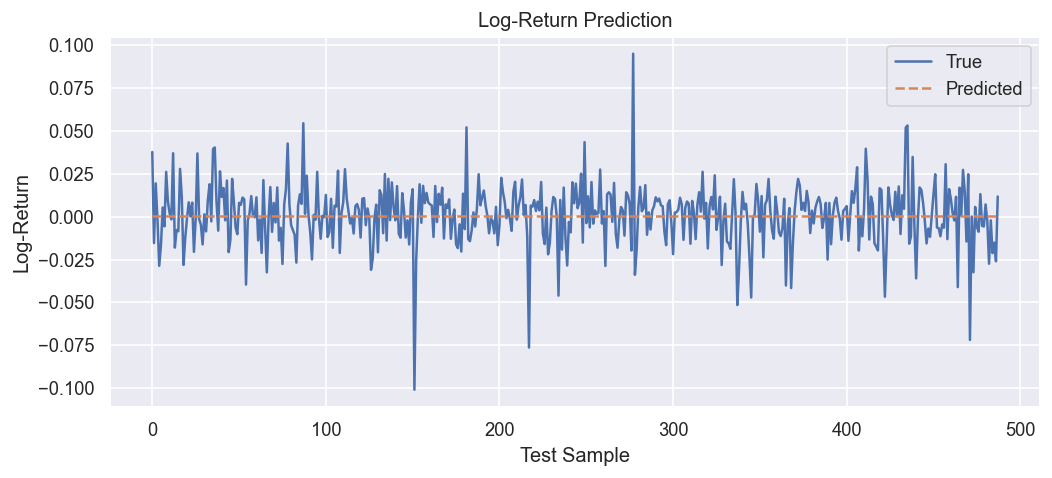


[Model Evaluation on Log-Return]
MAE:  0.0127
MSE:  0.0003
RMSE: 0.0176

[Naive Baseline: Predict Yesterday's Log-Return]
MAE:  0.0185
MSE:  0.0006
RMSE: 0.0248

[Performance Metrics]
Sharpe Ratio:      0.9762
Sortino Ratio:     1.2893
Max Drawdown:      -22.28%


In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import Huber

# ----------------------------------------------------------
# 0. Configuration & Seeding
# ----------------------------------------------------------
sns.set()
tf.random.set_seed(1234)
np.random.seed(1234)

# ----------------------------------------------------------
# 1. Download and Prepare the Data
# ----------------------------------------------------------
symbol     = 'GOOG'
start_date = '2015-01-01'
end_date   = '2025-03-03'
df         = yf.download(symbol, start=start_date, end=end_date)[['Open','High','Low','Close','Volume']]
df.dropna(inplace=True)

# compute log-return
df['LogReturn'] = np.log(df['Close']).diff()
df.dropna(inplace=True)

# ----------------------------------------------------------
# 2. Feature Engineering
# ----------------------------------------------------------
df['MA7'] = df['Close'].rolling(7).mean()

delta    = df['Close'].diff()
gain     = delta.clip(lower=0)
loss     = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs       = avg_gain / (avg_loss + 1e-8)
df['RSI'] = 100 - 100/(1 + rs)

ema12       = df['Close'].ewm(span=12, adjust=False).mean()
ema26       = df['Close'].ewm(span=26, adjust=False).mean()
macd_line   = ema12 - ema26
signal_line = macd_line.ewm(span=9, adjust=False).mean()
df['MACD']  = macd_line - signal_line

df['Momentum']   = df['Close'].diff(5)
df['Volatility'] = df['LogReturn'].rolling(10).std()

df.dropna(inplace=True)

features   = ['Open','High','Low','Close','Volume','MA7','RSI','MACD','Momentum','Volatility']
target_col = 'LogReturn'

# ----------------------------------------------------------
# 3. Train/Test Split
# ----------------------------------------------------------
train_ratio = 0.8
n_train     = int(len(df) * train_ratio)

train_df = df.iloc[:n_train]
test_df  = df.iloc[n_train:]

# ----------------------------------------------------------
# 4. Scale Features
# ----------------------------------------------------------
scaler = MinMaxScaler()
scaler.fit(train_df[features])
X_train = scaler.transform(train_df[features])
X_test  = scaler.transform(test_df[features])
y_train = train_df[target_col].values
y_test  = test_df[target_col].values

# ----------------------------------------------------------
# 5. Create Sequences
# ----------------------------------------------------------
def create_sequences(X, y, window=20):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

time_steps        = 20
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq,  y_test_seq  = create_sequences(X_test,  y_test,  time_steps)

# ----------------------------------------------------------
# 6. Build Model with Stronger Regularization
# ----------------------------------------------------------
class Attention(tf.keras.layers.Layer):
    def build(self, input_shape):
        dim = input_shape[-1]
        self.W = self.add_weight(shape=(dim, dim), name='att_weight',
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(dim,), name='att_bias',
                                 initializer='zeros', trainable=True)
        self.u = self.add_weight(shape=(dim,), name='att_u',
                                 initializer='random_normal', trainable=True)
    def call(self, x):
        v     = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        vu    = tf.tensordot(v, self.u, axes=1)
        alpha = tf.nn.softmax(vu)
        return tf.reduce_sum(x * tf.expand_dims(alpha, -1), axis=1)

def build_model(timesteps, n_features, lr=1e-3):
    inp = Input(shape=(timesteps, n_features))
    x   = LSTM(32, return_sequences=True,
               kernel_regularizer=regularizers.l2(1e-3))(inp)
    x   = Dropout(0.3)(x)
    x   = Attention()(x)
    x   = Dropout(0.3)(x)
    x   = Dense(16, activation='relu',
                kernel_regularizer=regularizers.l2(1e-3))(x)
    x   = Dropout(0.3)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=Huber(delta=0.5)
    )
    return model

model = build_model(time_steps, len(features))
model.summary()

# ----------------------------------------------------------
# 7. Train with EarlyStopping and LR Reduction
# ----------------------------------------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# ----------------------------------------------------------
# 8. Evaluate & Plot Loss and Predictions
# ----------------------------------------------------------
# 8a. Loss curve
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Huber Loss')
plt.legend(); plt.show()

# 8b. True vs Predicted log-returns
preds = model.predict(X_test_seq).ravel()
plt.figure(figsize=(10,4))
plt.plot(y_test_seq, label='True')
plt.plot(preds,   label='Predicted', linestyle='--')
plt.title('Log-Return Prediction')
plt.xlabel('Test Sample'); plt.ylabel('Log-Return')
plt.legend(); plt.show()

# ----------------------------------------------------------
# 9. Model Evaluation on Log-Return
# ----------------------------------------------------------
mse_val  = mean_squared_error(y_test_seq, preds)
rmse_val = np.sqrt(mse_val)
mae_val  = mean_absolute_error(y_test_seq, preds)
print("\n[Model Evaluation on Log-Return]")
print(f"MAE:  {mae_val:.4f}")
print(f"MSE:  {mse_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")

# ----------------------------------------------------------
# 10. Naive Baseline: Predict Yesterday's Log-Return
# ----------------------------------------------------------
naive_preds        = np.empty_like(y_test_seq)
naive_preds[0]     = 0.0
naive_preds[1:]    = y_test_seq[:-1]
mse_naive          = mean_squared_error(y_test_seq, naive_preds)
rmse_naive         = np.sqrt(mse_naive)
mae_naive          = mean_absolute_error(y_test_seq, naive_preds)
print("\n[Naive Baseline: Predict Yesterday's Log-Return]")
print(f"MAE:  {mae_naive:.4f}")
print(f"MSE:  {mse_naive:.4f}")
print(f"RMSE: {rmse_naive:.4f}")

# ----------------------------------------------------------
# 11. Performance Metrics: Sharpe, Sortino, Max Drawdown
# ----------------------------------------------------------
signals      = np.where(preds > 0, 1, -1)
strat_ret    = signals * y_test_seq

eps          = 1e-8
sharpe       = np.mean(strat_ret) / (np.std(strat_ret) + eps) * np.sqrt(252)
downside     = strat_ret[strat_ret < 0]
sortino      = np.mean(strat_ret) / (np.std(downside) + eps) * np.sqrt(252) if len(downside)>0 else np.nan

equity_curve = np.exp(np.cumsum(strat_ret))
running_max  = np.maximum.accumulate(equity_curve)
drawdown     = (equity_curve - running_max) / running_max
max_dd       = drawdown.min()

print("\n[Performance Metrics]")
print(f"Sharpe Ratio:      {sharpe:.4f}")
print(f"Sortino Ratio:     {sortino:.4f}")
print(f"Max Drawdown:      {max_dd:.2%}")

model.save("/Users/sum/Desktop/Github projects/LSTM with Attention for Log-Return Prediction.h5")
